In [13]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

# Separate features and targets

In [14]:
df = pd.read_csv('data/diabetic_data_initial.csv', na_values=['?'])
# separate feature and target data
X = df.iloc[:,:-1].copy()
y = df.iloc[:,-1].copy()

/opt/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1. Inspection

In [15]:
print('total number of samples: ', len(X))

total number of samples:  101766


In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

Only two dtypes: 
- Features that are **categorical**: those with `object` dtype  
  - features like `age`, `weight` should naturally be **numerical** instead of **categorical**, so they should be converted later if possible
- Features that are **numerical**: those with `int64` dtype
  - features like `admission_type_id`, `discharge_disposition_id`, `admission_source_id` are ordinal encodings of a category, so they are treated like **categorical** data

## Distribution Plot

In [17]:
plt.style.use('seaborn')
def display_distribution(feature_name):
    ser = df[feature_name]
    ser.hist(edgecolor='white', zorder=5)
    plt.title('Diabetic Patients {} Distribution'.format(feature_name))
    plt.xlabel('Class')
    plt.ylabel(feature_name)
    plt.savefig('img/'+feature_name)

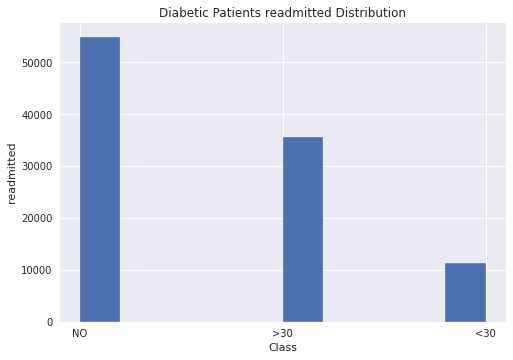

In [18]:
display_distribution('readmitted')

If we add up those that are readmitted beyond 30 days and those under 30 days, the label becomes binary, and the class distribution is more balanced.  
This step simplifies the model. 

In [19]:
print('NO:', (df['readmitted'] == 'NO').sum(), 'YES:', (df['readmitted'] != 'NO').sum())

NO: 54864 YES: 46902


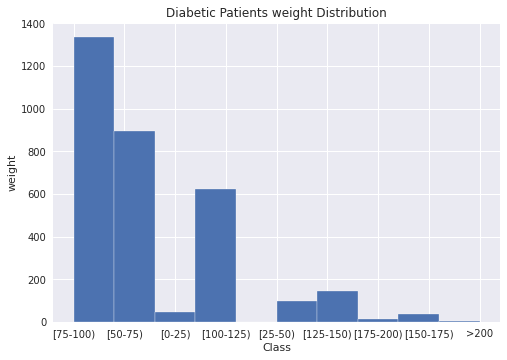

In [20]:
display_distribution('weight')

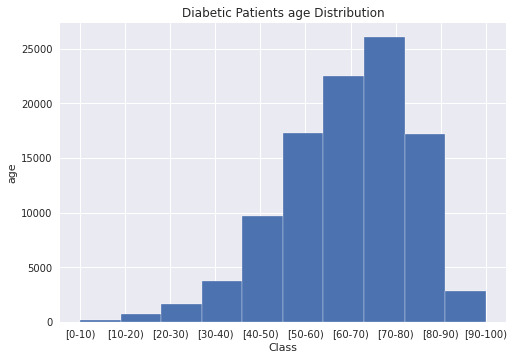

In [21]:
display_distribution('age')

In [22]:
X.loc[:,['encounter_id', 'patient_nbr']].nunique()

encounter_id    101766
patient_nbr      71518
dtype: int64

There are less patients than encounters. This means that some patients were readmitted more than once. `patient_nbr` in this case can uniquely identify each individual and will serve as the group of the samples. 

## Missing Values

In [23]:
missing_x = (100 * X.isna().sum() / len(df)).to_frame('% missing')
missing_x[missing_x['% missing'] > 0]

,% missing
race,2.233555
weight,96.858479
payer_code,39.557416
medical_specialty,49.082208
diag_1,0.020636
diag_2,0.351787
diag_3,1.398306


- features `weight`, `payer_code`, `medical_specialty` contain a high percentage of missing values

## Unique Values

Categorical Features

In [24]:
for col in X.select_dtypes(include='object').columns:
    if X[col].nunique() < 50:
        print('{:20s}:{}'.format(col, X[col].unique()))
    else:
        print('{:20s}:{} unique values'.format(col, X[col].nunique()))

race                :['Caucasian' 'AfricanAmerican' nan 'Other' 'Asian' 'Hispanic']
gender              :['Female' 'Male' 'Unknown/Invalid']
age                 :['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
weight              :[nan '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
payer_code          :[nan 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']
medical_specialty   :72 unique values
diag_1              :716 unique values
diag_2              :748 unique values
diag_3              :789 unique values
max_glu_serum       :['None' '>300' 'Norm' '>200']
A1Cresult           :['None' '>7' '>8' 'Norm']
metformin           :['No' 'Steady' 'Up' 'Down']
repaglinide         :['No' 'Up' 'Steady' 'Down']
nateglinide         :['No' 'Steady' 'Down' 'Up']
chlorpropamide      :['No' 'Steady' 'Down' 'Up']
glimepiride         :['No' 'Steady' 'Down' 'Up']
a

- `medical_specialty`, `diag_1`, `diag_2`, `diag_3` contain missing values, and also consist of many unique values. Encoding for these categorical data will be difficult. 
- features `examide` and `citoglipton` have exactly 1 unique value

Numerical Features

In [25]:
for col in X.select_dtypes(exclude='object').columns:
    if X[col].nunique() < 50:
        print('{:50s}:{}'.format(col, X[col].unique()))
    else:
        print('{:50s}:{} unique values'.format(col, X[col].nunique()))

encounter_id                                      :101766 unique values
patient_nbr                                       :71518 unique values
admission_type_id                                 :[6 1 2 3 4 5 8 7]
discharge_disposition_id                          :[25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]
admission_source_id                               :[ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]
time_in_hospital                                  :[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
num_lab_procedures                                :118 unique values
num_procedures                                    :[0 5 1 6 2 3 4]
num_medications                                   :75 unique values
number_outpatient                                 :[ 0  2  1  5  7  9  3  8  4 12 11  6 20 15 10 13 14 16 21 35 17 29 36 18
 19 27 22 24 42 39 34 26 33 25 23 28 37 38 40]
number_emergency                                  :[ 0  1  2  4  3  9  5  7  6  8 

# 2. Data Cleaning

## Drop

### Irrelevant columns

In [26]:
# feature that identifies samples
X.drop(['encounter_id'], axis=1, inplace=True)

# feature that identifies the group of the samples
group_x = X['patient_nbr'].copy()
X.drop(['patient_nbr'], axis=1, inplace=True)

### Missing values

In [27]:
# features with high percentage of missing values
X.drop(missing_x[missing_x['% missing'] > 10].index, axis=1, inplace=True)

# features with only one unique value
X.drop(X.columns[X.nunique() < 2], axis=1, inplace=True)

# features with too many unique values that are categorical
X.drop(X.select_dtypes('object').columns[X.select_dtypes('object').nunique() > 50], axis=1, inplace=True)

## Split and Preprocessing

In [28]:
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.impute

### Type Conversion

In [29]:
X_categorical = X.select_dtypes(include='object').astype('category')
print(X_categorical.columns)

# Encode categorical features (NaNs are encoded as -1)
for col in X_categorical.columns:
    X[col] = X_categorical[col].cat.codes

# Verify that age categories are encoded using its natural ordering
dict(enumerate(X_categorical['age'].cat.categories))

Index(['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed'],
      dtype='object')


{0: '[0-10)',
 1: '[10-20)',
 2: '[20-30)',
 3: '[30-40)',
 4: '[40-50)',
 5: '[50-60)',
 6: '[60-70)',
 7: '[70-80)',
 8: '[80-90)',
 9: '[90-100)'}

In [30]:
# Convert label to binary
y[y != 'NO'] = 'YES'
# Encode label
le = sklearn.preprocessing.LabelEncoder().fit(y)
y.iloc[:] = le.transform(y)
le.classes_

array(['NO', 'YES'], dtype=object)

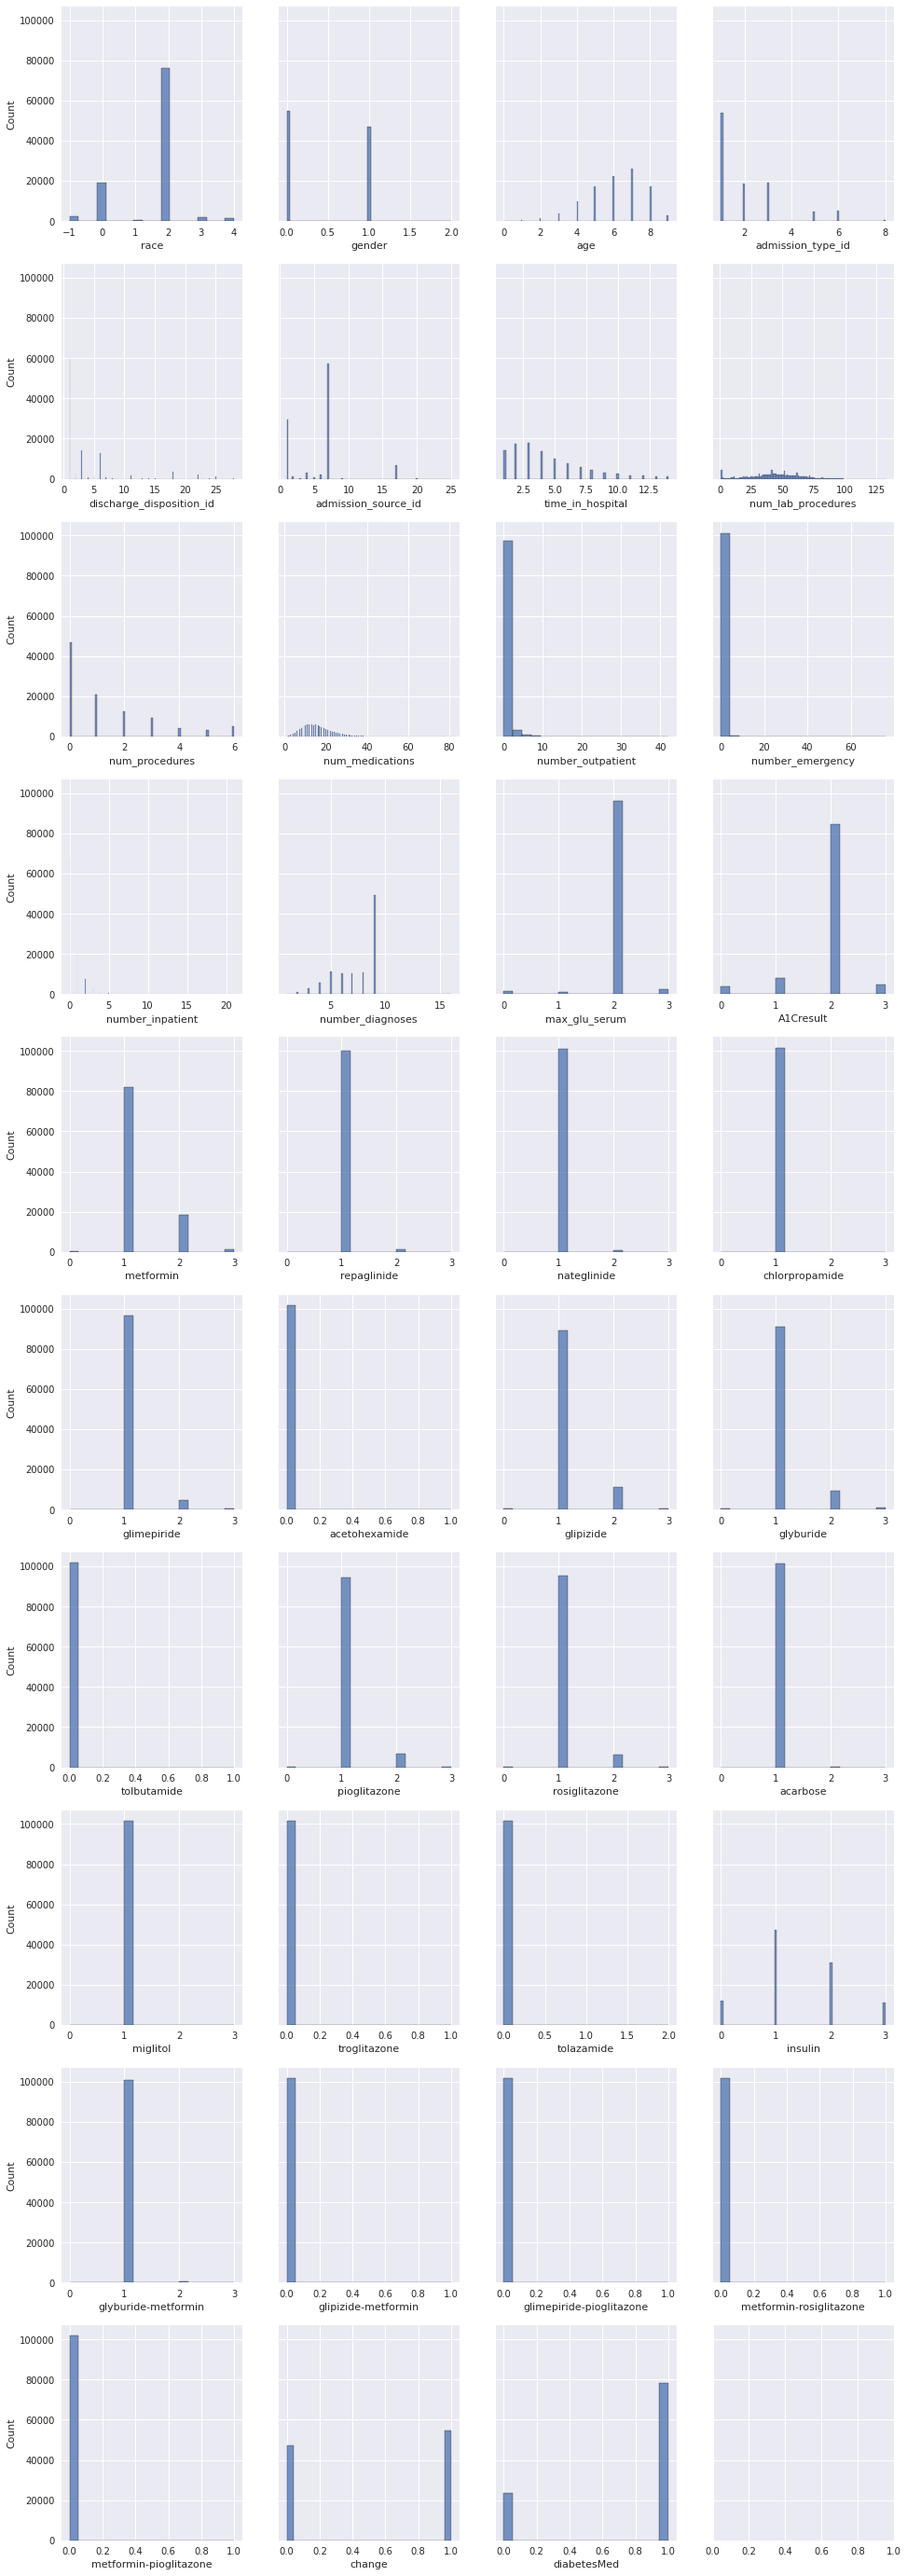

In [31]:
fig, axes = plt.subplots(nrows=10, ncols=4, sharey=True)
fig.set_size_inches(16,50)
for i, col in enumerate(X.columns):
    sns.histplot(X[col],ax=axes[i//4, i%4])

## Split data with GroupShuffleSplit, Impute with SimpleImputer

In [32]:
# Train-Test Split Strategy
gss = sklearn.model_selection.GroupShuffleSplit(n_splits=1, train_size=.9, random_state=42)
# Data Imputation Strategy
imp = sklearn.impute.SimpleImputer(missing_values=-1, strategy='most_frequent')

In [33]:
# split the full data 90:10 into training:testing sets based on groups of patient number
for train_index, test_index in gss.split(X, y, groups=group_x):
    X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
    y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
    group_train, group_test = group_x.iloc[train_index].copy(), group_x.iloc[test_index].copy()
    imp.fit(X_train)
    X_train.loc[:] = imp.transform(X_train)
    X_test.loc[:] = imp.transform(X_test)

In [34]:
# features with only one unique value
X_test.drop(X_train.columns[X_train.nunique() < 2], axis=1, inplace=True)
X_train.drop(X_train.columns[X_train.nunique() < 2], axis=1, inplace=True)

In [35]:
pd.concat([X_train, y_train], axis=1).to_csv('data/training.csv', index=False)

pd.concat([X_test, y_test], axis=1).to_csv('data/testing.csv', index=False)

group_train.to_csv('data/group_training.csv', index=False)

group_test.to_csv('data/group_testing.csv', index=False)